<a href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL/blob/master/FinRL_StockTrading_NeurIPS_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)   
* [RLlib Section](#7)            

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library


In [ ]:
## install finrl library
#!pip install git+https://github.com/AI4Finance-Foundation/FinRL-Library.git

  Cloning https://github.com/AI4Finance-Foundation/FinRL-Library.git to /private/var/folders/6h/lpcm_n7d1hg47zhs852wxbt40000gn/T/pip-req-build-38817uwr
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL-Library.git /private/var/folders/6h/lpcm_n7d1hg47zhs852wxbt40000gn/T/pip-req-build-38817uwr



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime
from finrl import config
from finrl import config_tickers
import os


%matplotlib inline
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
#from finrl.finrl_meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/home/mohammad/anaconda3/envs/FinRl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mohammad/anaconda3/envs/FinRl/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


<a id='1.4'></a>
## 2.4. Create Folders

# Part 3: Download Data



-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


## 3.1 use yahoo finance api to get DOWJONES 

In [ ]:
df = YahooDownloader(start_date = datetime.datetime(2009, 1, 1),
                     end_date = datetime.datetime.now(),
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

In [6]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [7]:
df.shape

(99520, 8)

In [13]:
df.sort_values(['date','tic'],ignore_index=True).head()

,close,high,low,open,s,date,volume,tic
0,6745.20000,6747.20000,6649.30000,6677.30000,ok,2020-01-02,8870,OANDA:AU200_AUD
1,0.90669,0.91094,0.90631,0.91046,ok,2020-01-02,61630,OANDA:AUD_CAD
2,0.67841,0.67955,0.67653,0.67837,ok,2020-01-02,9141,OANDA:AUD_CHF
3,5.44260,5.47053,5.43560,5.45912,ok,2020-01-02,20773,OANDA:AUD_HKD
4,75.81700,76.31600,75.66600,76.17200,ok,2020-01-02,50501,OANDA:AUD_JPY
...,...,...,...,...,...,...,...,...
81296,86.66000,88.45700,86.59100,87.88800,ok,2022-07-29,94219,OANDA:XAU_XAG
81297,3.57603,3.57852,3.44541,3.47622,ok,2022-07-29,40022,OANDA:XCU_USD
81298,2120.97800,2133.46200,2028.78800,2073.98900,ok,2022-07-29,15364,OANDA:XPD_USD
81299,888.25400,897.23500,875.16600,878.05500,ok,2022-07-29,48385,OANDA:XPT_USD


## 3.2 use Finnhub api to get forex market data

#### read all symbols data and save as csv file

In [13]:
import os
forex_data_path = '/mnt/c/Users/Lenovo/financial_projects/Deep Reinforcement Learning Approaches on Stock Prediction/FinRL/forex_data'

In [14]:
import finnhub
import pandas as pd
finnhub_client = finnhub.Client(api_key='cbj22uqad3i2thcmtg80')
forex_symbols = finnhub_client.forex_symbols(exchange='oanda')
#finnhub_client.stock_candles('')

In [15]:
def read_and_save_forex_candles(symbol_name, stock_df):
    shape = stock_df.shape
    data_list = [symbol_name] * shape[0]
    stock_df['symbol'] = data_list
    stock_df.to_csv(os.path.join(forex_data_path,symbol_name + '.csv'))


In [19]:
i = 0
for symbol in forex_symbols :
    i +=1
    print(i)
    if i > 120 :
        holcv_symbol = finnhub_client.stock_candles(symbol = symbol['symbol'], resolution = '60', _from = 1577824200, to = 1659250244)
        holcv_symbol_df = pd.DataFrame(holcv_symbol)
        read_and_save_forex_candles(symbol['symbol'], holcv_symbol_df)


    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


#### read symbols data from csv file and merge all of them

In [20]:
forex_market_dataset = pd.DataFrame() 
for symbol in forex_symbols :
    forex_symbol_data = pd.read_csv(os.path.join(forex_data_path, symbol['symbol'] + '.csv'), index_col= [0])
    forex_market_dataset = pd.concat([forex_market_dataset, forex_symbol_data])

In [21]:
forex_market_dataset

,c,h,l,o,s,t,v,symbol
0,10.74194,10.74598,10.72380,10.73798,ok,1656655200,1906,OANDA:EUR_SEK
1,10.74974,10.75475,10.74045,10.74189,ok,1656658800,4135,OANDA:EUR_SEK
2,10.75836,10.77679,10.74605,10.74954,ok,1656662400,5160,OANDA:EUR_SEK
3,10.76398,10.76636,10.75189,10.75736,ok,1656666000,4004,OANDA:EUR_SEK
4,10.77179,10.77819,10.75824,10.76409,ok,1656669600,3086,OANDA:EUR_SEK
...,...,...,...,...,...,...,...,...
490,396.48000,397.23000,395.93000,396.19000,ok,1659110400,3240,OANDA:USD_HUF
491,396.17600,396.86900,395.93600,396.45000,ok,1659114000,2485,OANDA:USD_HUF
492,395.56000,396.41000,395.41700,396.17600,ok,1659117600,1224,OANDA:USD_HUF
493,395.27500,395.82200,395.23400,395.44600,ok,1659121200,3003,OANDA:USD_HUF


#### cleaning forex_symbols dataframe

In [22]:
forex_market_dataset.rename(columns={'c':'close','h':'high','l':'low','o':'open','t':'date','v':'volume', 'symbol':'tic'}, inplace= True)

In [23]:
dates = []
import datetime
for date in forex_market_dataset['date']:
    dates.append(datetime.datetime.fromtimestamp(date,).strftime("%Y-%m-%d, %H:%M:%S"))

In [24]:
dates

['2022-07-01, 10:30:00',
 '2022-07-01, 11:30:00',
 '2022-07-01, 12:30:00',
 '2022-07-01, 13:30:00',
 '2022-07-01, 14:30:00',
 '2022-07-01, 15:30:00',
 '2022-07-01, 16:30:00',
 '2022-07-01, 17:30:00',
 '2022-07-01, 18:30:00',
 '2022-07-01, 19:30:00',
 '2022-07-01, 20:30:00',
 '2022-07-01, 21:30:00',
 '2022-07-01, 22:30:00',
 '2022-07-01, 23:30:00',
 '2022-07-02, 00:30:00',
 '2022-07-04, 01:30:00',
 '2022-07-04, 02:30:00',
 '2022-07-04, 03:30:00',
 '2022-07-04, 04:30:00',
 '2022-07-04, 05:30:00',
 '2022-07-04, 06:30:00',
 '2022-07-04, 07:30:00',
 '2022-07-04, 08:30:00',
 '2022-07-04, 09:30:00',
 '2022-07-04, 10:30:00',
 '2022-07-04, 11:30:00',
 '2022-07-04, 12:30:00',
 '2022-07-04, 13:30:00',
 '2022-07-04, 14:30:00',
 '2022-07-04, 15:30:00',
 '2022-07-04, 16:30:00',
 '2022-07-04, 17:30:00',
 '2022-07-04, 18:30:00',
 '2022-07-04, 19:30:00',
 '2022-07-04, 20:30:00',
 '2022-07-04, 21:30:00',
 '2022-07-04, 22:30:00',
 '2022-07-04, 23:30:00',
 '2022-07-05, 00:30:00',
 '2022-07-05, 01:30:00',


In [25]:
forex_market_dataset['date'] = dates

In [26]:
forex_market_dataset

,close,high,low,open,s,date,volume,tic
0,10.74194,10.74598,10.72380,10.73798,ok,"2022-07-01, 10:30:00",1906,OANDA:EUR_SEK
1,10.74974,10.75475,10.74045,10.74189,ok,"2022-07-01, 11:30:00",4135,OANDA:EUR_SEK
2,10.75836,10.77679,10.74605,10.74954,ok,"2022-07-01, 12:30:00",5160,OANDA:EUR_SEK
3,10.76398,10.76636,10.75189,10.75736,ok,"2022-07-01, 13:30:00",4004,OANDA:EUR_SEK
4,10.77179,10.77819,10.75824,10.76409,ok,"2022-07-01, 14:30:00",3086,OANDA:EUR_SEK
...,...,...,...,...,...,...,...,...
490,396.48000,397.23000,395.93000,396.19000,ok,"2022-07-29, 20:30:00",3240,OANDA:USD_HUF
491,396.17600,396.86900,395.93600,396.45000,ok,"2022-07-29, 21:30:00",2485,OANDA:USD_HUF
492,395.56000,396.41000,395.41700,396.17600,ok,"2022-07-29, 22:30:00",1224,OANDA:USD_HUF
493,395.27500,395.82200,395.23400,395.44600,ok,"2022-07-29, 23:30:00",3003,OANDA:USD_HUF


In [27]:
forex_market_dataset.sort_values(['date', 'tic'], ignore_index = True)
forex_market_dataset.drop(columns='s', inplace = True)
forex_market_dataset

,close,high,low,open,date,volume,tic
0,10.74194,10.74598,10.72380,10.73798,"2022-07-01, 10:30:00",1906,OANDA:EUR_SEK
1,10.74974,10.75475,10.74045,10.74189,"2022-07-01, 11:30:00",4135,OANDA:EUR_SEK
2,10.75836,10.77679,10.74605,10.74954,"2022-07-01, 12:30:00",5160,OANDA:EUR_SEK
3,10.76398,10.76636,10.75189,10.75736,"2022-07-01, 13:30:00",4004,OANDA:EUR_SEK
4,10.77179,10.77819,10.75824,10.76409,"2022-07-01, 14:30:00",3086,OANDA:EUR_SEK
...,...,...,...,...,...,...,...
490,396.48000,397.23000,395.93000,396.19000,"2022-07-29, 20:30:00",3240,OANDA:USD_HUF
491,396.17600,396.86900,395.93600,396.45000,"2022-07-29, 21:30:00",2485,OANDA:USD_HUF
492,395.56000,396.41000,395.41700,396.17600,"2022-07-29, 22:30:00",1224,OANDA:USD_HUF
493,395.27500,395.82200,395.23400,395.44600,"2022-07-29, 23:30:00",3003,OANDA:USD_HUF


## 3.3 : use finnhub to get crypto market data  

In [2]:
import finnhub
import pandas as pd
finnhub_client = finnhub.Client(api_key='cbj22uqad3i2thcmtg80')

### read crypto symbols

In [3]:
binance_crypto_symbols = finnhub_client.crypto_symbols('BINANCE')

### load crypto_candles

In [10]:
def preprocess_crypto_candles(symbol_name, stock_df):
    shape = stock_df.shape
    data_list = [symbol_name] * shape[0]
    stock_df['symbol'] = data_list
    return stock_df

In [11]:
def read_symbol_candles(symbol,start,end):
    candles_data = finnhub_client.crypto_candles(symbol, resolution='D', 
    _from = calendar.timegm(start),
    to = calendar.timegm(end) 
    )
    return candles_data

In [12]:
import datetime
import calendar
import pandas as pd
import time
start = datetime.date(2019,1,1).timetuple()
end = datetime.datetime.utcnow().utctimetuple()
crypto_symbols_df = pd.DataFrame()
for symbol in binance_crypto_symbols:
    if symbol['displaySymbol'].split('/')[1] == 'ETH': 
        candles_data = read_symbol_candles(symbol['symbol'], start, end)
        if (candles_data['s'] != 'no_data'):
            preprocessed_crypto_candles = preprocess_crypto_candles(symbol['symbol'],pd.DataFrame(candles_data))
            crypto_symbols_df = pd.concat([crypto_symbols_df, preprocessed_crypto_candles])

KeyboardInterrupt: 

In [57]:
crypto_symbols_df

,c,h,l,o,s,t,v,symbolName
0,0.000271,0.000380,0.000271,0.000289,ok,1637280000,285417.40,BINANCE:CHRETH
1,0.000320,0.001411,0.000266,0.000269,ok,1637366400,723537.60,BINANCE:CHRETH
2,0.000286,0.000316,0.000283,0.000316,ok,1637452800,235387.30,BINANCE:CHRETH
3,0.000317,0.000323,0.000284,0.000288,ok,1637539200,378017.00,BINANCE:CHRETH
4,0.000291,0.000336,0.000291,0.000317,ok,1637625600,374254.00,BINANCE:CHRETH
...,...,...,...,...,...,...,...,...
93,0.001509,0.001575,0.001501,0.001530,ok,1650153600,8422.85,BINANCE:DYDXETH
94,0.001498,0.001534,0.001408,0.001507,ok,1650240000,32293.46,BINANCE:DYDXETH
95,0.001615,0.001666,0.001473,0.001500,ok,1650326400,24104.95,BINANCE:DYDXETH
96,0.001577,0.001670,0.001571,0.001618,ok,1650412800,50355.34,BINANCE:DYDXETH


In [58]:
crypto_symbols_df.rename(columns={'c':'close','h':'high','l':'low','o':'open','t':'date','v':'volume','symbolName':'tic'},inplace=True)

In [59]:
crypto_symbols_df.drop(columns={'s'}, inplace=True)

## 3.4 : use numerai api to load data

In [69]:
from numerapi import NumerAPI
napi = NumerAPI()

In [70]:
napi.download_dataset("v4/train.parquet", "train.parquet")


2022-08-07 21:56:43,523 INFO numerapi.utils: resuming download
/home/mohammad/anaconda3/envs/FinRl/lib/python3.8/site-packages/urllib3/connectionpool.py:1043: InsecureRequestWarning: Unverified HTTPS request is being made to host 'numerai-datasets.s3.amazonaws.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
train.parquet: 1.15GB [1:02:56, 303kB/s]                            


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [28]:
data = forex_market_dataset.copy()

In [34]:
fe = FeatureEngineer(
                    use_technical_indicator = True,
                    tech_indicator_list =  config.INDICATORS,
                    use_vix=True ,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(data)


In [17]:
processed.dropna(axis=1)

,close,high,low,open,date,volume,tic,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,5334.80000,5397.80000,5280.90000,5324.90000,2020-04-28,23233,OANDA:AU200_AUD,0.000000,5624.037669,5196.662331,100.000000,66.666667,100.000000,5334.800000,5334.800000,33.57,0.000000
1,0.90832,0.91077,0.90363,0.90646,2020-04-28,153814,OANDA:AUD_CAD,0.000000,5624.037669,5196.662331,100.000000,66.666667,100.000000,0.908320,0.908320,33.57,0.000000
2,0.63258,0.63471,0.62780,0.63013,2020-04-28,22160,OANDA:AUD_CHF,0.000000,5624.037669,5196.662331,100.000000,66.666667,100.000000,0.632580,0.632580,33.57,0.000000
3,5.02929,5.04782,4.98639,5.00724,2020-04-28,21854,OANDA:AUD_HKD,0.000000,5624.037669,5196.662331,100.000000,66.666667,100.000000,5.029290,5.029290,33.57,0.000000
4,69.34700,69.55700,69.02400,69.27300,2020-04-28,127498,OANDA:AUD_JPY,0.000000,5624.037669,5196.662331,100.000000,66.666667,100.000000,69.347000,69.347000,33.57,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64045,87.69500,90.99800,87.65100,90.78300,2022-07-28,114688,OANDA:XAU_XAG,1.104141,93.774468,87.878332,51.613140,-9.383006,5.250027,89.105300,86.534383,22.33,543.560159
64046,3.47820,3.51092,3.43632,3.45557,2022-07-28,42595,OANDA:XCU_USD,-0.134359,3.670252,3.105437,39.340369,-24.350856,16.256019,3.564819,3.929196,22.33,543.560159
64047,2071.49100,2088.46200,2012.01500,2021.00700,2022-07-28,23749,OANDA:XPD_USD,16.175992,2150.846101,1768.417199,52.240639,127.587256,33.679498,1918.039133,1981.920600,22.33,543.560159
64048,878.55400,887.83600,866.56600,877.64300,2022-07-28,51472,OANDA:XPT_USD,-11.947073,901.967114,813.041986,46.376416,-2.043388,2.314447,877.934000,914.888450,22.33,543.560159


In [18]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [19]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(29)

,date,tic,close,high,low,open,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-04-28,OANDA:AU200_AUD,5334.80000,5397.80000,5280.90000,5324.90000,23233.0,0.0,5624.037669,5196.662331,100.0,66.666667,100.0,5334.80000,5334.80000,33.57,0.0
1,2020-04-28,OANDA:AUD_CAD,0.90832,0.91077,0.90363,0.90646,153814.0,0.0,5624.037669,5196.662331,100.0,66.666667,100.0,0.90832,0.90832,33.57,0.0
2,2020-04-28,OANDA:AUD_CHF,0.63258,0.63471,0.62780,0.63013,22160.0,0.0,5624.037669,5196.662331,100.0,66.666667,100.0,0.63258,0.63258,33.57,0.0
3,2020-04-28,OANDA:AUD_HKD,5.02929,5.04782,4.98639,5.00724,21854.0,0.0,5624.037669,5196.662331,100.0,66.666667,100.0,5.02929,5.02929,33.57,0.0
4,2020-04-28,OANDA:AUD_JPY,69.34700,69.55700,69.02400,69.27300,127498.0,0.0,5624.037669,5196.662331,100.0,66.666667,100.0,69.34700,69.34700,33.57,0.0
5,2020-04-28,OANDA:AUD_NZD,1.07109,1.07499,1.06787,1.06832,159050.0,0.0,5624.037669,5196.662331,100.0,66.666667,100.0,1.07109,1.07109,33.57,0.0
6,2020-04-28,OANDA:AUD_SGD,0.91937,0.92200,0.91463,0.91617,56769.0,0.0,5624.037669,5196.662331,100.0,66.666667,100.0,0.91937,0.91937,33.57,0.0
7,2020-04-28,OANDA:AUD_USD,0.64896,0.65133,0.64336,0.64613,13114.0,0.0,5624.037669,5196.662331,100.0,66.666667,100.0,0.64896,0.64896,33.57,0.0
8,2020-04-28,OANDA:BCO_USD,20.43700,21.05400,19.39000,20.32100,79257.0,0.0,5624.037669,5196.662331,100.0,66.666667,100.0,20.43700,20.43700,33.57,0.0
9,2020-04-28,OANDA:CAD_CHF,0.69619,0.69827,0.69353,0.69484,22146.0,0.0,5624.037669,5196.662331,100.0,66.666667,100.0,0.69619,0.69619,33.57,0.0


<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

## Training data and Trading data split

In [20]:
# from config.py TRAIN_START_DATE is a string
#config.TRAIN_START_DATE
train_start_date = '2020-1-2'
# from config.py TRAIN_END_DATE is a string
train_end_date = '2021-7-29'
trade_end_date = '2022-7-29'
train = data_split(processed_full, train_start_date ,train_end_date)
trade = data_split(processed_full, train_end_date ,trade_end_date)
print(len(train))
print(len(trade))

35868
15860


In [21]:
train.tail()

,date,tic,close,high,low,open,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
293,2021-12-30,OANDA:XAU_XAG,78.70700,79.53000,78.20300,79.00000,21625.0,0.647290,81.132486,78.013714,54.789287,20.886770,13.702796,78.186100,76.934383,17.33,100.789117
293,2021-12-30,OANDA:XCU_USD,4.37739,4.42526,4.36927,4.40473,68713.0,0.008653,4.415258,4.202050,51.538202,91.454608,1.758419,4.322295,4.353693,17.33,100.789117
293,2021-12-30,OANDA:XPD_USD,1959.92600,2012.31300,1939.19100,1975.46900,39752.0,-3.661727,1995.621772,1579.807428,50.486785,60.803847,18.521898,1853.885133,1931.236917,17.33,100.789117
293,2021-12-30,OANDA:XPT_USD,965.30100,976.07200,960.57300,971.42600,98869.0,-8.512193,975.068116,898.850584,47.774623,2.677386,2.980694,963.480967,995.329017,17.33,100.789117
293,2021-12-30,OANDA:ZAR_JPY,7.22900,7.24000,7.17900,7.19500,5797.0,-0.014404,7.294747,6.990853,47.950079,29.034354,14.567020,7.177267,7.357200,17.33,100.789117


In [22]:
trade.head()

,date,tic,close,high,low,open,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2022-01-04,OANDA:AU200_AUD,7606.90000,7654.90000,7475.00000,7495.00000,21300.0,44.240379,7568.139084,7159.070916,60.176208,236.836928,44.965889,7352.530000,7364.340000,16.91,256.922322
0,2022-01-04,OANDA:AUD_CAD,0.91970,0.92046,0.91567,0.91590,28387.0,0.002689,0.933138,0.896449,50.890613,47.481029,6.955564,0.914429,0.917726,16.91,256.922322
0,2022-01-04,OANDA:AUD_CHF,0.66312,0.66394,0.65960,0.66031,13381.0,-0.001196,0.669019,0.647762,47.535229,1.692004,2.546837,0.661819,0.671174,16.91,256.922322
0,2022-01-04,OANDA:AUD_HKD,5.64150,5.64930,5.60014,5.60519,13783.0,0.000930,5.683049,5.470264,49.588441,60.101726,0.371233,5.590350,5.673383,16.91,256.922322
0,2022-01-04,OANDA:AUD_JPY,84.07400,84.17000,82.83300,82.84300,82162.0,0.287060,83.975820,78.906980,56.388052,122.931894,25.081571,81.756267,82.815133,16.91,256.922322


In [217]:
#config.INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [23]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 122, State Space: 1221


In [24]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": config.INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [25]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.
* FinRL library includes fine-tuned standard DRL algorithms, such as DQN, DDPG,
Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


In [46]:
checkpoint_path = '/mnt/c/Users/Lenovo/financial_projects/Deep Reinforcement Learning Approaches on Stock Prediction/FinRL/trained_models_on_forex_market'
import os

### Model 1: A2C


In [47]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007, 'device': device(type='cuda', index=0)}
Using cpu device


In [49]:
model_name = 'a2c_'
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)
trained_a2c.save(os.path.join(checkpoint_path, model_name + ".pth"))

---------------------------------------
| time/                 |             |
|    fps                | 23          |
|    iterations         | 100         |
|    time_elapsed       | 20          |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -173        |
|    explained_variance | 0           |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 17.4        |
|    reward             | -0.39639515 |
|    std                | 1           |
|    value_loss         | 0.0454      |
---------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 30        |
|    iterations         | 200       |
|    time_elapsed       | 32        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -174      |
|    explained_variance | 0         |
|    learning_rate

### Model 2: DDPG

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device


In [ ]:
model_name  = 'DDPG_'
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)
trained_ddpg.save(os.path.join(checkpoint_path, model_name + ".pth"))

: 

### Model 3: PPO

In [40]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128, 'device': device(type='cuda', index=0)}
Using cpu device


In [41]:
model_ppo.device

device(type='cpu')

In [146]:
model_name  = 'ppo_'
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)
trained_ppo.save(os.path.join(checkpoint_path, model_name + ".pth"))

------------------------------------
| time/              |             |
|    fps             | 58          |
|    iterations      | 1           |
|    time_elapsed    | 34          |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.05581534 |
------------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 60          |
|    iterations           | 2           |
|    time_elapsed         | 67          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015701083 |
|    clip_fraction        | 0.211       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | -0.00337    |
|    learning_rate        | 0.00025     |
|    loss                 | 7.31        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0184  

### Model 4: TD3

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

In [ ]:
model_name ='td3_'
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)
trained_td3.save(os.path.join(checkpoint_path, model_name + ".pth"))

### Model 5: SAC

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

In [ ]:
model_name = 'sac_'
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)
trained_sac.save(os.path.join(checkpoint_path, model_name + ".pth"))

### Model 6: recurrentppo

In [34]:
import os
import numpy as np

from sb3_contrib import RecurrentPPO
from stable_baselines3.common.evaluation import evaluate_policy



In [35]:
checkpoint_path = '/mnt/c/Users/Lenovo/financial_projects/Deep Reinforcement Learning Approaches on Stock Prediction/FinRL/trained_models_on_forex_market'
model = RecurrentPPO("MlpLstmPolicy", env=env_train, verbose=1)
model.learn(5000)
model_version = '5000_iter_'
model_name = 'recurrent_ppo'

env = model.get_env()
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20, warn=False)
print(mean_reward)

model.save(os.path.join(checkpoint_path, model_version + model_name  + ".pth"))

Using cpu device
----------------------------
| time/              |     |
|    fps             | 3   |
|    iterations      | 1   |
|    time_elapsed    | 35  |
|    total_timesteps | 128 |
----------------------------
---------------------------------------
| time/                   |           |
|    fps                  | 2         |
|    iterations           | 2         |
|    time_elapsed         | 116       |
|    total_timesteps      | 256       |
| train/                  |           |
|    approx_kl            | 13.765079 |
|    clip_fraction        | 0.616     |
|    clip_range           | 0.2       |
|    entropy_loss         | -136      |
|    explained_variance   | -0.0287   |
|    learning_rate        | 0.0003    |
|    loss                 | 1.13      |
|    n_updates            | 10        |
|    policy_gradient_loss | -0.164    |
|    std                  | 1         |
|    value_loss           | 2.4       |
---------------------------------------
--------------------

# Trading
Assume that we have $1,000,000 initial capital at 2020-07-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [36]:
data_risk_indicator = processed_full[(processed_full.date<trade_end_date) & (processed_full.date> train_end_date)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [37]:
insample_risk_indicator.vix.describe()

count    130.000000
mean      26.250385
std        4.302689
min       16.910000
25%       23.137500
50%       26.295000
75%       29.577501
max       36.450001
Name: vix, dtype: float64

In [38]:
insample_risk_indicator.vix.quantile(0.996)

35.76888092041017

In [39]:
insample_risk_indicator.turbulence.describe()

count    130.000000
mean     299.667703
std      180.576643
min       82.298171
25%      176.133761
50%      250.516150
75%      366.892880
max      971.055868
Name: turbulence, dtype: float64

In [40]:
insample_risk_indicator.turbulence.quantile(0.996)

970.3374543334523

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [41]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [42]:
trade.head()

,date,tic,close,high,low,open,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2022-01-04,OANDA:AU200_AUD,7606.90000,7654.90000,7475.00000,7495.00000,21300.0,44.240379,7568.139084,7159.070916,60.176208,236.836928,44.965889,7352.530000,7364.340000,16.91,256.922322
0,2022-01-04,OANDA:AUD_CAD,0.91970,0.92046,0.91567,0.91590,28387.0,0.002689,0.933138,0.896449,50.890613,47.481029,6.955564,0.914429,0.917726,16.91,256.922322
0,2022-01-04,OANDA:AUD_CHF,0.66312,0.66394,0.65960,0.66031,13381.0,-0.001196,0.669019,0.647762,47.535229,1.692004,2.546837,0.661819,0.671174,16.91,256.922322
0,2022-01-04,OANDA:AUD_HKD,5.64150,5.64930,5.60014,5.60519,13783.0,0.000930,5.683049,5.470264,49.588441,60.101726,0.371233,5.590350,5.673383,16.91,256.922322
0,2022-01-04,OANDA:AUD_JPY,84.07400,84.17000,82.83300,82.84300,82162.0,0.287060,83.975820,78.906980,56.388052,122.931894,25.081571,81.756267,82.815133,16.91,256.922322


In [154]:
df_account_value, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

hit end!


In [155]:
df_account_value.shape

(336, 2)

In [156]:
df_account_value.tail()

,date,account_value
331,2021-10-22,1.356524e+06
332,2021-10-25,1.360173e+06
333,2021-10-26,1.359589e+06
334,2021-10-27,1.353222e+06
335,2021-10-28,1.364491e+06


In [158]:
import os
df_actions.head()
df_actions.to_csv(os.path.join('/mnt/c/Users/Lenovo/financial_projects/Deep Reinforcement Learning Approaches on Stock Prediction/FinRL/results/ppo_50000_total_timesteps','actions.csv'))

### Trade by recurrentppo

we use recurrent ppo as alternative to finrl's drl agents beacause our env is partially observable and we need memory so we use recurrent ppo (lstm ppo) for using of recurrent prediction 


In [43]:
#trade = data_split(processed_full, '2020-07-01','2021-10-31')
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
env_trade, obs_trade = e_trade_gym.get_sb_env()

In [44]:
model_version = '5000_iter_'
model_name = 'recurrent_ppo'
model = RecurrentPPO.load(os.path.join(checkpoint_path,  model_version + model_name + ".pth"))

In [45]:
account_memory = []
actions_memory = []
lstm_states = None
num_envs = 1
episode_starts = np.ones((num_envs,), dtype=bool)
#         state_memory=[] #add memory pool to store states
env_trade.reset()
for i in range(len(e_trade_gym.df.index.unique())):
    action, lstm_states = model.predict(obs_trade, state=lstm_states, episode_start=episode_starts, deterministic=True)
            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
    obs_trade, rewards, dones, info = env_trade.step(action)
    episode_starts = dones
    env_trade.render()
    if i == (len(e_trade_gym.df.index.unique()) - 2):
        account_memory = env_trade.env_method(method_name="save_asset_memory")
        actions_memory = env_trade.env_method(method_name="save_action_memory")
#                 state_memory=test_env.env_method(method_name="save_state_memory") # add current state to state memory
    if dones[0]:
        print(i)
        print("hit end!")


129
hit end!


In [46]:
df_account_value = pd.DataFrame(account_memory[0])
df_actions_memory = pd.DataFrame(actions_memory[0])

In [47]:
df_account_value

,date,account_value
0,2022-01-04,1000000.000000
1,2022-01-05,990771.492678
2,2022-01-06,981721.451505
3,2022-01-07,975672.094010
4,2022-01-10,970723.108037
...,...,...
125,2022-07-22,944906.748409
126,2022-07-25,944806.566228
127,2022-07-26,939165.324259
128,2022-07-27,953622.082400


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [48]:
print("==============Get Backtest Results===========")
result_path = '/mnt/c/Users/Lenovo/financial_projects/Deep Reinforcement Learning Approaches on Stock Prediction/FinRL/results'
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv(os.path.join(result_path,'perf_stats_all_' + model_name +  model_version + ".csv"))

==============Get Backtest Results===========


/home/mohammad/anaconda3/envs/FinRl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Annual return         -0.081961
Cumulative returns    -0.043156
Annual volatility      0.146628
Sharpe ratio          -0.514798
Calmar ratio          -0.903929
Stability              0.163390
Max drawdown          -0.090672
Omega ratio            0.919856
Sortino ratio         -0.703531
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.092203
Daily value at risk   -0.018773
dtype: float64


In [49]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')
stats.to_csv(os.path.join(result_path,'baseline_stats' + ".csv"))


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (142, 8)
Annual return         -0.202847
Cumulative returns    -0.119925
Annual volatility      0.197479
Sharpe ratio          -1.057359
Calmar ratio          -1.080137
Stability              0.725496
Max drawdown          -0.187797
Omega ratio            0.841497
Sortino ratio         -1.406212
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.832190
Daily value at risk   -0.025709
dtype: float64


/mnt/c/Users/Lenovo/financial_projects/Deep Reinforcement Learning Approaches on Stock Prediction/FinRL/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/home/mohammad/anaconda3/envs/FinRl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [50]:
df_account_value.loc[0,'date']

'2022-01-04'

In [51]:
df_account_value.loc[len(df_account_value)-1,'date']

'2022-07-28'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed


/mnt/c/Users/Lenovo/financial_projects/Deep Reinforcement Learning Approaches on Stock Prediction/FinRL/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


Shape of DataFrame:  (142, 8)


/home/mohammad/anaconda3/envs/FinRl/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2022-01-04
End date,2022-07-28
Total months,6
,Backtest
Annual return,-8.196%
Cumulative returns,-4.316%
Annual volatility,14.663%
Sharpe ratio,-0.51
Calmar ratio,-0.90
Stability,0.16
Max drawdown,-9.067%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.07,2022-01-04,2022-06-16,NaT,NaN
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


/home/mohammad/anaconda3/envs/FinRl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/mohammad/anaconda3/envs/FinRl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/mohammad/anaconda3/envs/FinRl/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/mohammad/anaconda3/envs/FinRl/lib/python3.8/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be

ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2022-07-28 00:00:00+0000', tz='UTC'))

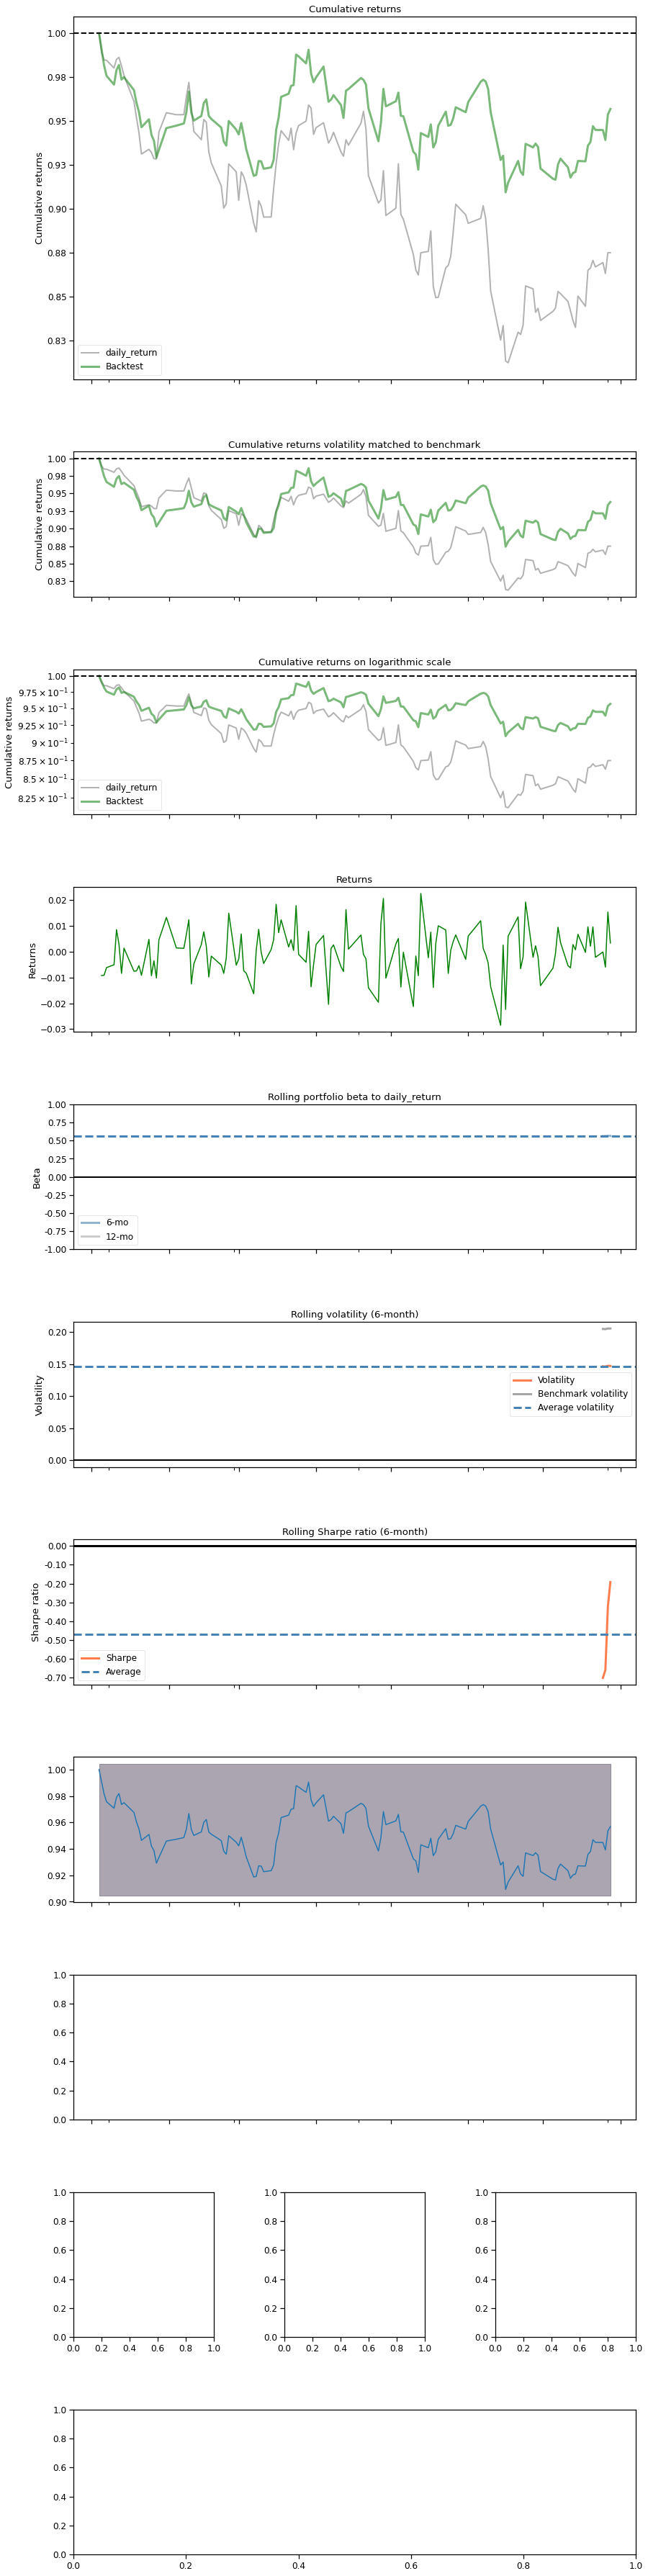

In [52]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])